# Introductory tutorial for PASTAQ DDA data exploration and processing
## Load pastaq and raw data
This tutorial shows the basic functionality of PASTAQ library provided by python binding.

First load pastaq as well other packages for visualisation and some basic data analysis. Then load the LC-MS(/MS) file in mzML or mzXML format using the `read_mzml` or `read_mzxml` function. Set the average full width at half maximum (`avg_fwhm_rt`) of the chromatographic peak. Then load the default parameters for Orbitrap using `default_parameters` function and change required parameters (in this case MS2 resolution).

In [1]:
import pastaq as pq
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

# file name and location of the example file
exampleFile1 = "./SmallExampleData_DDA/3_1_extract_3400_4100_590_615.mzML"
exampleFile2 = "./SmallExampleData_DDA/3_2_extract_3400_4100_590_615.mzML"
avg_fwhm_rt = 9 # default 15

# load example file
lcmsData1 = pq.read_mzml(file_name = exampleFile1, min_mz = -1, max_mz = -1, min_rt = -1, max_rt = -1, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 1)
lcmsData2 = pq.read_mzml(file_name = exampleFile2, min_mz = -1, max_mz = -1, min_rt = -1, max_rt = -1, instrument_type = 'ORBITRAP', resolution_ms1 = 70000, resolution_msn = 17500, reference_mz = 200, fwhm_rt = avg_fwhm_rt, polarity = '+', ms_level = 1)
params = pq.default_parameters(instrument = 'orbitrap', avg_fwhm_rt = avg_fwhm_rt)
params['resolution_msn'] = 17500
print(params)

{'instrument_type': 'orbitrap', 'resolution_ms1': 70000, 'resolution_msn': 17500, 'reference_mz': 200, 'avg_fwhm_rt': 9, 'num_samples_mz': 5, 'num_samples_rt': 5, 'smoothing_coefficient_mz': 0.4, 'smoothing_coefficient_rt': 0.4, 'warp2d_slack': 30, 'warp2d_window_size': 100, 'warp2d_num_points': 2000, 'warp2d_rt_expand_factor': 0.2, 'warp2d_peaks_per_window': 100, 'metamatch_fraction': 0.7, 'metamatch_n_sig_mz': 1.5, 'metamatch_n_sig_rt': 1.5, 'feature_detection_charge_states': [5, 4, 3, 2, 1], 'max_peaks': 1000000, 'polarity': 'both', 'min_mz': 0, 'max_mz': 100000, 'min_rt': 0, 'max_rt': 100000, 'link_n_sig_mz': 3, 'link_n_sig_rt': 3, 'ident_max_rank_only': True, 'ident_require_threshold': True, 'ident_ignore_decoy': True, 'similarity_num_peaks': 2000, 'qc_plot_palette': 'husl', 'qc_plot_extension': 'png', 'qc_plot_fill_alpha': 'dynamic', 'qc_plot_line_alpha': 0.5, 'qc_plot_scatter_alpha': 0.3, 'qc_plot_scatter_size': 2, 'qc_plot_min_dynamic_alpha': 0.1, 'qc_plot_per_file': False, 'qc

Print the main characteristics of LC-MS(/MS) data and the first 20 intensities of the MS1 spectra with id of 20.

Main characteristics of LCMS data:
 <bound method PyCapsule.dump of RawData:
> instrument_type: ORBITRAP
> resolution_ms1: 70000.000000
> resolution_msn: 17500.000000
> reference_mz: 200.000000
> min_mz: 590.000099
> max_mz: 614.999939
> min_rt: 3400.143000
> max_rt: 4098.910680
> number of scans: 879> 

First 20 intensity of scan  10 :
 [123137.6640625, 198857.796875, 186504.703125, 110450.796875, 30861.353515625, 51615.1875, 93108.640625, 108093.6484375, 77396.5, 24463.44921875, 29560.482421875, 76585.5234375, 94415.8671875, 70456.1171875, 33264.14453125, 54325.26953125, 121243.7578125, 180292.203125, 110860.3984375]


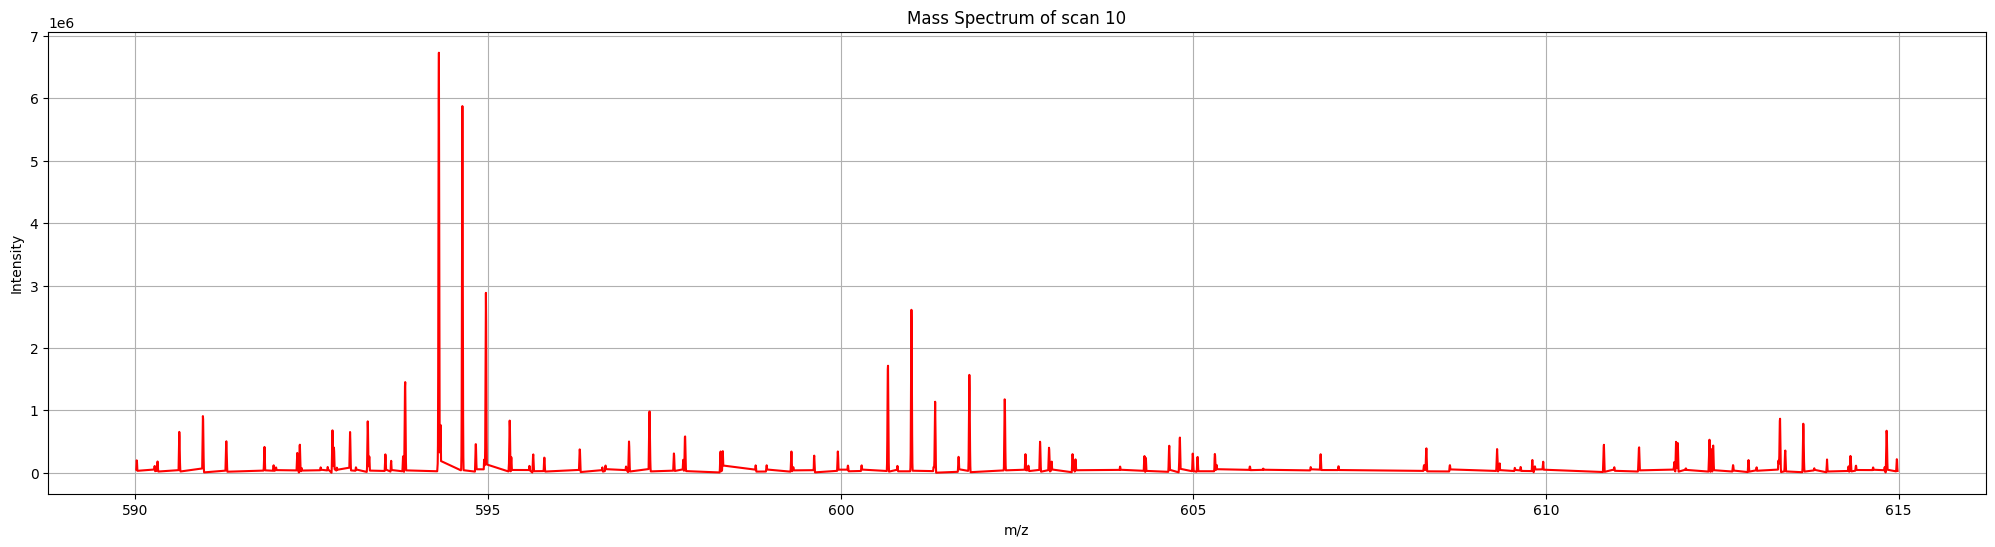

In [2]:
scanIdx = 10
print('Main characteristics of LCMS data:\n', lcmsData1.dump, '\n')
# print('Main properties of an LCMS scan:\n', dir(lcmsData1.scans[scanIdx]), '\n')
print('First 20 intensity of scan ', scanIdx, ':\n', lcmsData1.scans[scanIdx].intensity[1:20])

# plot the mass spectra of scan 10
plt.figure(figsize=(25, 6))  # Set the figure size
plt.plot(lcmsData1.scans[scanIdx].mz, lcmsData1.scans[scanIdx].intensity, color = 'red', marker='', linestyle='-')  # Plot mz vs. intensity
plt.xlabel('m/z')  # Set the x-axis label
plt.ylabel('Intensity')  # Set the y-axis label
plt.title('Mass Spectrum of scan {}' .format(scanIdx))  # Set the title
plt.grid(True)  # Show grid
plt.show()  # Show the plot

In [3]:
print(dir(pq))
# help(pq.resample)

['DBSequence', 'Feature', 'FeatureCluster', 'FeatureId', 'Grid', 'IdentData', 'InferredProtein', 'Instrument', 'LinkedMsms', 'LinkedPsm', 'Peak', 'PeakCluster', 'PeakId', 'Peptide', 'PeptideEvidence', 'PeptideModification', 'Polarity', 'PrecursorInformation', 'RawData', 'RawPoints', 'Scan', 'Similarity', 'SpectrumMatch', 'TimeMap', 'Xic', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_custom_log', 'calculate_similarity_matrix', 'calculate_time_map', 'colors', 'create_quantitative_tables', 'datetime', 'dda_pipeline', 'dda_pipeline_summary', 'default_parameters', 'detect_features', 'detect_peaks', 'find_feature_clusters', 'find_peak_clusters', 'find_peaks', 'find_protein_groups', 'find_sequence_consensus', 'find_similarity', 'generate_qc_plots', 'gridspec', 'json', 'link_idents', 'link_peaks', 'link_peaks_msms_idents', 'link_psm', 'logging', 'match_peaks_and_features', 'np', 'os', 'parse_mzidentml_files', 'parse_raw

## Perform smoothing and resampling of MS1 data using 2D Gaussian kernel density
- Perform the smoothing.
- Plot the smooth and resampled data as heatmap showing TIC and spectra sum with the `plot_mesh` function.

{'img_plot': <Axes: xlabel='m/z', ylabel='retention time (s)'>,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intensity'>}

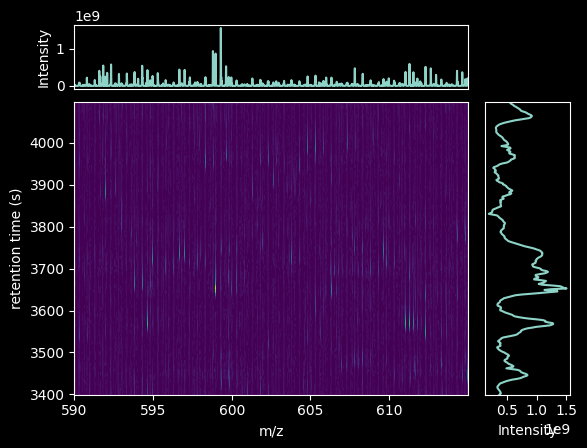

In [4]:
grid1 = pq.resample(
            lcmsData1,
            params['num_samples_mz'],
            params['num_samples_rt'],
            params['smoothing_coefficient_mz'],
            params['smoothing_coefficient_rt'],
)
pq.plot_mesh(grid1, transform='sqrt', figure=None)

In [5]:
peaks1 = pq.find_peaks(lcmsData1, grid1, params['max_peaks'])
# print(grid.data[0:200])
print(peaks1[1:10])

[Peak <id: 1, local_max_mz: 599.304220, local_max_rt: 3648.034876, local_max_height: 47523574.823666, fitted_height: 67651612.533288, fitted_mz: 599.304449, fitted_rt: 3652.832330, fitted_sigma_mz: 0.005504, fitted_sigma_rt: 8.270211, fitted_volume: 19347381.073116>, Peak <id: 2, local_max_mz: 598.969421, local_max_rt: 3653.423830, local_max_height: 57365207.533737, fitted_height: 66998007.868652, fitted_mz: 598.970177, fitted_rt: 3652.645077, fitted_sigma_mz: 0.005545, fitted_sigma_rt: 8.344026, fitted_volume: 19476674.626150>, Peak <id: 3, local_max_mz: 598.969421, local_max_rt: 3648.034876, local_max_height: 47086755.710709, fitted_height: 66330593.693451, fitted_mz: 598.970242, fitted_rt: 3651.929790, fitted_sigma_mz: 0.005548, fitted_sigma_rt: 7.500576, fitted_volume: 17342813.995841>, Peak <id: 4, local_max_mz: 599.304220, local_max_rt: 3671.387009, local_max_height: 45828778.419747, fitted_height: 51086089.393415, fitted_mz: 599.303850, fitted_rt: 3670.976603, fitted_sigma_mz: 0

In [6]:
features1 = pq.detect_features(peaks1, params['feature_detection_charge_states'])
print(features1[1:10])

[Feature <id: 1, average_rt: 3652.921380, average_mz: 599.327177, total_height: 187438172.038085, monoisotopic_mz: 598.970242, monoisotopic_height: 66330593.693451, charge_state: 3, n_isotopes: 7>, Feature <id: 2, average_rt: 3571.506811, average_mz: 611.372861, total_height: 112350022.606281, monoisotopic_mz: 611.041138, monoisotopic_height: 29896671.466309, charge_state: 4, n_isotopes: 5>, Feature <id: 3, average_rt: 3673.193575, average_mz: 599.180113, total_height: 116365916.037104, monoisotopic_mz: 598.802325, monoisotopic_height: 49116103.847503, charge_state: 2, n_isotopes: 4>, Feature <id: 4, average_rt: 3570.952491, average_mz: 611.287972, total_height: 92831162.016167, monoisotopic_mz: 611.041100, monoisotopic_height: 28616000.260151, charge_state: 4, n_isotopes: 3>, Feature <id: 5, average_rt: 4061.967835, average_mz: 591.819757, total_height: 85962632.679836, monoisotopic_mz: 591.580292, monoisotopic_height: 27542085.957335, charge_state: 4, n_isotopes: 3>, Feature <id: 6, 

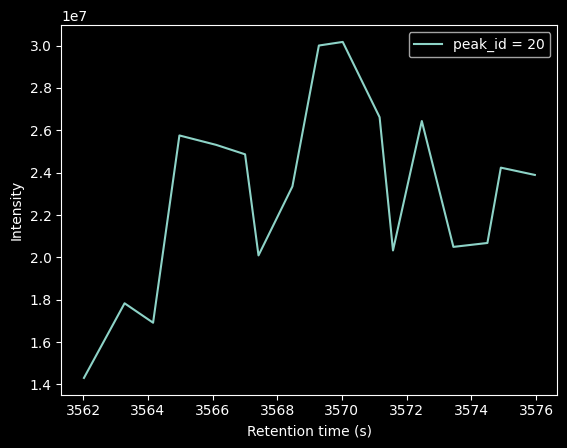

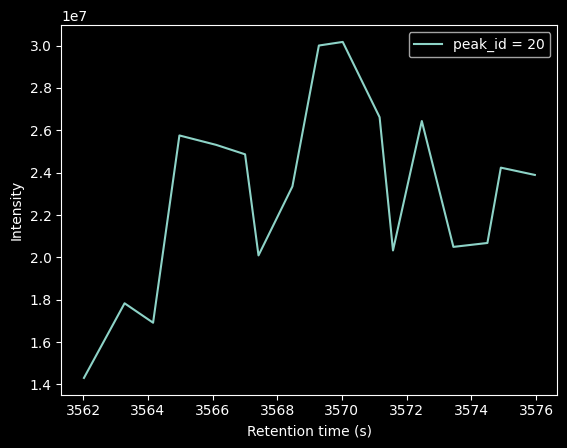

In [7]:
fill_alpha = params['qc_plot_fill_alpha']
line_alpha = params['qc_plot_line_alpha']
scatter_alpha = params['qc_plot_scatter_alpha']
palette = sns.color_palette(params['qc_plot_palette'], 10)

pq.plot_xic(peaks1[20], lcmsData1, figure=None, method="max")

{'img_plot': <Axes: >,
 'mz_plot': <Axes: ylabel='Intensity'>,
 'rt_plot': <Axes: xlabel='Intensity'>}

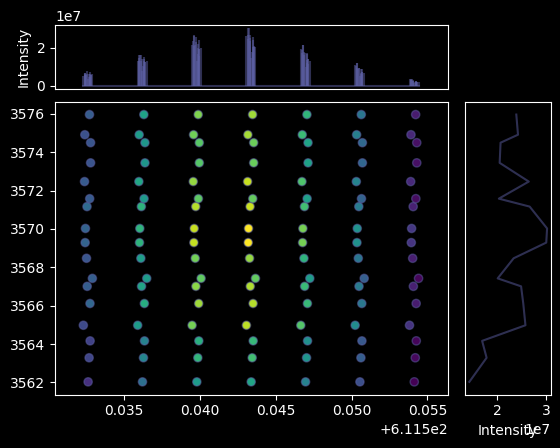

In [8]:
pq.plot_peak_raw_points(
        peaks1[20],
        lcmsData1,
        img_plot=None,
        rt_plot=None,
        mz_plot=None,
        xic_method="max")

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 37234.86328125, 0.0, 193569.8828125, 0.0, 0.0, 0.0, 175920.015625, 0.0, 0.0, 0.0, 0.0, 129410.546875, 269332.2192020416, 102708.40625, 234432.375, 316184.3876953125, 87837.7734375, 532917.58984375, 547200.8984375, 879772.9296875, 972145.951171875, 751403.37109375, 1036708.125, 1487893.1875, 1137398.9296875, 802215.49609375, 1026822.4375, 1773785.203125, 1641732.4453125, 1952700.296875, 2698175.046875, 2590056.90625, 1930516.296875, 3010462.421875, 2938944.53125, 3368577.21875, 3755017.875, 3130724.046875, 3585568.8125, 4065387.125, 2875744.9375, 3284371.59375, 4254163.90625, 3932160.6875, 4860200.5625, 4369902.0, 5648873.1875, 4435937.75, 5036355.625, 4550010.59375, 4263535.625, 4898098.625, 4387453.75, 5137711.5, 3888987.96875, 4094757.59375, 324204.369140625, 1789257.296875, 3387342.5, 3060388.125, 2502677.0, 2363895.75, 1955732.734375, 2275485.84375, 2183704.015625, 2726376.78125, 1648690.6406

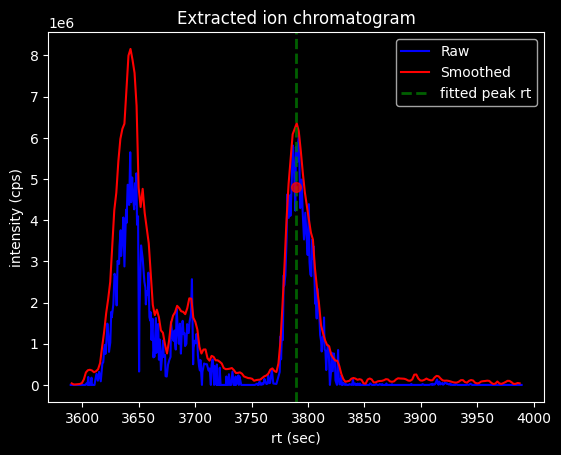

In [11]:
peakIdx = 255
lowBoundmz = peaks1[peakIdx].fitted_mz-peaks1[peakIdx].fitted_sigma_mz
highBoundmz = peaks1[peakIdx].fitted_mz+peaks1[peakIdx].fitted_sigma_mz
lowBoundrt = peaks1[peakIdx].fitted_rt-200
highBoundrt = peaks1[peakIdx].fitted_rt+200
xic = pq.xic(lcmsData1, lowBoundmz, highBoundmz, lowBoundrt, highBoundrt)
print(xic.intensity)

np.array(grid1.bins_mz, dtype=np.float64)
indices_mz = [i for i, val in enumerate(np.array(grid1.bins_mz, dtype=np.float64)) if lowBoundmz < val < highBoundmz]
indices_rt = [i for i, val in enumerate(np.array(grid1.bins_rt, dtype=np.float64)) if lowBoundrt < val < highBoundrt]
xicGrid = np.array(grid1.data).reshape(grid1.m, grid1.n)
xicGridi = xicGrid[indices_rt][:, indices_mz]
xicGridis = np.sum(xicGridi, axis=1)
xicGridrt = np.array(grid1.bins_rt, dtype=np.float64)[indices_rt]

plt.plot(xic.retention_time, xic.intensity, label='Raw', alpha=1, color='blue')
plt.plot(xicGridrt, xicGridis, label='Smoothed', alpha=1, color='red')
plt.axvline(x=peaks1[peakIdx].fitted_rt, label='fitted peak rt', color='green', alpha=0.75, linestyle='--', linewidth=2)
print(dir(peaks1[peakIdx]), peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_height)
plt.plot(peaks1[peakIdx].fitted_rt, peaks1[peakIdx].fitted_height*2.3, marker='o', markersize=7, color='red', alpha=0.75)
plt.xlabel('rt (sec)')
plt.ylabel('intensity (cps)')
plt.title('Extracted ion chromatogram')
plt.legend()
plt.show()